In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm, ListedColormap, LinearSegmentedColormap
import matplotlib.colors as mcolors
from matplotlib import ticker
from matplotlib.ticker import EngFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
import seaborn as sns
import bioframe as bf
import cooler
import cooltools
import warnings
from cytoolz import merge


# Settings for plotting
mpl.rc('lines', linewidth=0.4)
mpl.rc('font', family='Helvetica', size=8)
mpl.rc('axes', labelsize=8, titlesize=8, linewidth=0.4)
mpl.rc('legend', fontsize=8)
mpl.rc('xtick', labelsize=6)
mpl.rc('xtick.major', width=0.4, size=3)
mpl.rc('xtick.minor', width=0.4, size=1.5)
mpl.rc('ytick', labelsize=6)
mpl.rc('ytick.major', width=0.4, size=3)
mpl.rc('ytick.minor', width=0.4, size=1.5)

colors = {'NeuN+': sns.color_palette()[4], 
          'NeuN-': sns.color_palette()[1]}


# Set up some functions
class MidPointLogNorm(LogNorm):
    """
    Borrowed from: https://stackoverflow.com/questions/48625475/python-shifted-logarithmic-colorbar-white-color-offset-to-center
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        LogNorm.__init__(self,vmin=vmin, vmax=vmax, clip=clip)
        self.midpoint=midpoint
    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        x, y = [np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)], [0, 0.5, 1]
        return np.ma.array(np.interp(np.log(value), x, y), mask=result.mask, copy=False)


def saddleplot(
    track,
    saddledata,
    n_bins,
    vrange=None,
    qrange=(0.0, 1.0),
    cmap="coolwarm",
    scale="log",
    vmin=0.5,
    vmax=2,
    color=None,
    title=None,
    xlabel=None,
    ylabel=None,
    clabel=None,
    fig=None,
    fig_kws=None,
    heatmap_kws=None,
    margin_kws=None,
    cbar_kws=None,
    subplot_spec=None,
):
    """
    Function is taken from cooltools package
    Generate a saddle plot.
    Parameters
    ----------
    track : pd.DataFrame
        See cooltools.digitize() for details.
    saddledata : 2D array-like
        Saddle matrix produced by `make_saddle`. It will include 2 flanking
        rows/columns for outlier signal values, thus the shape should be
        `(n+2, n+2)`.
    cmap : str or matplotlib colormap
        Colormap to use for plotting the saddle heatmap
    scale : str
        Color scaling to use for plotting the saddle heatmap: log or linear
    vmin, vmax : float
        Value limits for coloring the saddle heatmap
    color : matplotlib color value
        Face color for margin bar plots
    fig : matplotlib Figure, optional
        Specified figure to plot on. A new figure is created if none is
        provided.
    fig_kws : dict, optional
        Passed on to `plt.Figure()`
    heatmap_kws : dict, optional
        Passed on to `ax.imshow()`
    margin_kws : dict, optional
        Passed on to `ax.bar()` and `ax.barh()`
    cbar_kws : dict, optional
        Passed on to `plt.colorbar()`
    subplot_spec : GridSpec object
        Specify a subregion of a figure to using a GridSpec.
    Returns
    -------
    Dictionary of axes objects.
    """

    from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
    from matplotlib.colors import Normalize, LogNorm, TwoSlopeNorm
    from matplotlib import ticker
    import matplotlib.pyplot as plt


    track_value_col = track.columns[3]
    track_values = track[track_value_col].values

    digitized_track, binedges = cooltools.digitize(
        track, n_bins, vrange=vrange, qrange=qrange
    )
    x = digitized_track[digitized_track.columns[3]].values.astype(int).copy()
    x = x[(x > -1) & (x < len(binedges) + 1)]

    groupmean = track[track.columns[3]].groupby(digitized_track[digitized_track.columns[3]]).mean()

    if qrange is not None:
        lo, hi = qrange
        binedges = np.linspace(lo, hi, n_bins + 1)

    # Barplot of mean values and saddledata are flanked by outlier bins
    n = saddledata.shape[0]
    X, Y = np.meshgrid(binedges, binedges)
    C = saddledata
    if (n - n_bins) == 2:
        C = C[1:-1, 1:-1]
        groupmean = groupmean[1:-1]

    # Layout
    if subplot_spec is not None:
        GridSpec = partial(GridSpecFromSubplotSpec, subplot_spec=subplot_spec)
    grid = {}
    gs = GridSpec(
        nrows=3,
        ncols=3,
        width_ratios=[0.15, 1, 0.1],
        height_ratios=[0.15, 1, 0.1],
        wspace=0.05,
        hspace=0.05,
    )

    # Figure
    if fig is None:
        fig_kws_default = dict(figsize=(5, 5))
        fig_kws = merge(fig_kws_default, fig_kws if fig_kws is not None else {})
        fig = plt.figure(**fig_kws)

    # Heatmap
    if scale == "log":
        norm = LogNorm(vmin=vmin, vmax=vmax)
    elif scale == "linear":
        norm = TwoSlopeNorm(vmin=vmin, vcenter=1, vmax=vmax)
    else:
        raise ValueError("Only linear and log color scaling is supported")

    grid["ax_heatmap"] = ax = plt.subplot(gs[4])
    heatmap_kws_default = dict(cmap="coolwarm", rasterized=True)
    heatmap_kws = merge(
        heatmap_kws_default, heatmap_kws if heatmap_kws is not None else {}
    )
    img = ax.pcolormesh(X, Y, C, norm=norm, **heatmap_kws)
    plt.gca().yaxis.set_visible(False)
    plt.gca().set_aspect('equal', 'box')

    # Margins
    margin_kws_default = dict(edgecolor="k", facecolor=color, linewidth=0)
    margin_kws = merge(margin_kws_default, margin_kws if margin_kws is not None else {})
    # left margin hist
    grid["ax_margin_y"] = plt.subplot(gs[3], sharey=grid["ax_heatmap"])

    plt.barh(
        binedges, height=1/len(binedges), width=groupmean, align="edge", **margin_kws
    )

    plt.xlim([-1, 1])
    
    plt.ylim(hi, lo)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["left"].set_visible(False)
    # top margin hist
    grid["ax_margin_x"] = plt.subplot(gs[1], sharex=grid["ax_heatmap"])

    plt.bar(
        binedges, width=1/len(binedges), height=groupmean, align="edge", **margin_kws
    )

    plt.xlim(lo, hi)
    plt.ylim([-1, 1])
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().xaxis.set_visible(False)

    # Colorbar
    grid["ax_cbar"] = plt.subplot(gs[5])
    cbar_kws_default = dict(fraction=0.8, label=clabel or "")
    cbar_kws = merge(cbar_kws_default, cbar_kws if cbar_kws is not None else {})
    if scale == "linear" and vmin is not None and vmax is not None:
        grid["cbar"] = cb = plt.colorbar(img, **cbar_kws)
    else:
        grid["cbar"] = cb = plt.colorbar(img, **cbar_kws)
        cb.ax.yaxis.set_major_locator(ticker.FixedLocator([round(vmin, 2), 1, round(vmax, 2)]))
        cb.ax.yaxis.set_minor_locator(ticker.FixedLocator([]))  

    # extra settings
    grid["ax_heatmap"].set_xlim(lo, hi)
    grid["ax_heatmap"].set_ylim(hi, lo)
    plt.grid(False)
    plt.axis("off")
    if title is not None:
        grid["ax_margin_x"].set_title(title)
    if xlabel is not None:
        grid["ax_heatmap"].set_xlabel(xlabel)
    if ylabel is not None:
        grid["ax_margin_y"].set_ylabel(ylabel)
        
    return grid, C

# Input data to run this notebook

In [1]:
# Paths to cooler matrices of different replicates (R1-R4) and combined one (merged)
# Run 1_merge_Hi-C.sh script to obtain merged maps
clr_path = {
    "NeuN+": {
        'R1': '../data/GSM7178441_HC-91plus.hg38.mapq_30.1000.mcool',
        'R2': '../data/GSM7178442_HC-318_NeuN_plus.hg38.mapq_30.1000.mcool',
        'R3': '../data/GSM7178443_HC2M_NeuN_plus.hg38.mapq_30.1000.mcool',
        'R4': '../data/GSM7178444_HC3M_NeuN_plus.hg38.mapq_30.1000.mcool',
        'merged': "../data/NeuNplus.sampled.1000.mcool"
    },
    "NeuN-": {
        'R1': '../data/GSM7178445_HC-91minus.hg38.mapq_30.1000.mcool',
        'R2': '../data/GSM7178446_HC-318_NeuN_minus.hg38.mapq_30.1000.mcool',
        'R3': '../data/GSM7178447_HC2M_NeuN_minus.hg38.mapq_30.1000.mcool',
        'R4': '../data/GSM7178448_HC3M_NeuN_minus.hg38.mapq_30.1000.mcool',
        'merged': "../data/NeuNminus.sampled.1000.mcool"
    }
}

# Histone H3K27ac abundance profile
"""
"Abundance" was calculated as follows:
Number of nucleotides within H3K27ac peak in a given bin divided by the bin length (50 kbp). 
"""
hist_ab_path = "../data/histone_abundance.tsv.gz"

# Calculate eigenvectors

In [4]:
# Load updated, merged HC hi-c matrices 
res = 50_000
cts = list(clr_path.keys())
reps = list(clr_path[cts[0]].keys())

clrs = {ct: {rep:
        cooler.Cooler(clr_path[ct][rep] + f'::resolutions/{res}') 
        for rep in reps} for ct in cts}

clrs

{'NeuN+': {'R1': <Cooler "sampled_HC-2Mplus_drop_diag_1K.mcool::/resolutions/50000">,
  'R2': <Cooler "sampled_HC-318plus_drop_diag_1K.mcool::/resolutions/50000">,
  'R3': <Cooler "sampled_HC-3Mplus_drop_diag_1K.mcool::/resolutions/50000">,
  'R4': <Cooler "sampled_HC-91plus_drop_diag_1K.mcool::/resolutions/50000">,
  'merged': <Cooler "sampled_plus_drop_diag_1K.mcool::/resolutions/50000">},
 'NeuN-': {'R1': <Cooler "sampled_HC-2Mminus_drop_diag_1K.mcool::/resolutions/50000">,
  'R2': <Cooler "sampled_HC-318minus_drop_diag_1K.mcool::/resolutions/50000">,
  'R3': <Cooler "sampled_HC-3Mminus_drop_diag_1K.mcool::/resolutions/50000">,
  'R4': <Cooler "sampled_HC-91minus_drop_diag_1K.mcool::/resolutions/50000">,
  'merged': <Cooler "sampled_minus_drop_diag_1K.mcool::/resolutions/50000">}}

In [5]:
# Fetch chromsizes and calculate GC-content
hg38_chromsizes = bf.fetch_chromsizes('hg38')
hg38_cens_sad = bf.fetch_centromeres('hg38')

# Create a view with chromosome arms using chromosome sizes and definition of centromeres
hg38_arms = bf.make_chromarms(hg38_chromsizes,  hg38_cens_sad)
hg38_arms = hg38_arms.loc[~hg38_arms['name'].isin(['chr13_p', 'chr14_p', 'chr15_p', 'chr21_p', 
                                                   'chr22_p', 'chrY_p', 'chrY_q', 'chrM_p'])]\
                     .reset_index(drop=True)

In [6]:
# Drop bins removed by balancing in at least one map
bad_bins = {}

# bad_bins_bal = pd.Index([])
for rep in reps:
    bad_bins[rep] = pd.Index([])
    for ct in cts:
    # for rep in ['merged']:
        a = clrs[ct][rep].bins()[:]['weight']
        bad_bins[rep] = bad_bins[rep].union(a[a != a].index)

# bad_bins = pd.Index([])
# bad_bins = bad_bins.union(bad_bins_bal)
bad_bins[rep][:10]

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='object')

In [7]:
# Load histone abundance profile
hist_ab = pd.read_table(hist_ab_path)
 
hist_ph = {
    'NeuN+': hist_ab[['chr', 'start', 'stop', 'Neun_h3k27ac']]\
        .rename(columns={'chr': 'chrom', 'stop': 'end', 'Neun_h3k27ac': 'value'}),
    'NeuN-': hist_ab[['chr', 'start', 'stop', 'Glia_h3k27ac']]\
        .rename(columns={'chr': 'chrom', 'stop': 'end', 'Glia_h3k27ac': 'value'})
}

In [8]:
# obtain first 5 eigenvectors
cis_eigs = {ct: {} for ct in cts}

for ct in cts:
    print(ct)
    for rep in reps:
        cis_eigs[ct][rep] = cooltools.eigs_cis(
                                clrs[ct][rep],
                                phasing_track=hist_ph[ct],
                                view_df=hg38_arms,
                                n_eigs=5,
                                bad_bins=bad_bins[rep],
                                sort_metric='spearmanr'
                            )

NeuN+
NeuN-


In [9]:
# Combine eigs to a single dataframe
eig_df = cis_eigs[cts[0]][reps[0]][1][['chrom', 'start', 'end']]

for ct in cts:
    for rep in reps:
        df2 = cis_eigs[ct][rep][1][['chrom','start','end','E1', 'E2']]\
            .rename(columns={'E1': f'E1.{ct}.{rep}',
                             'E2': f'E2.{ct}.{rep}'})
        eig_df = eig_df.merge(df2, on=['chrom', 'start', 'end'], validate="1:1")
            
print(eig_df.shape)
eig_df.head()

(61776, 23)


,chrom,start,end,E1.NeuN+.R1,E2.NeuN+.R1,E1.NeuN+.R2,E2.NeuN+.R2,E1.NeuN+.R3,E2.NeuN+.R3,E1.NeuN+.R4,...,E1.NeuN-.R1,E2.NeuN-.R1,E1.NeuN-.R2,E2.NeuN-.R2,E1.NeuN-.R3,E2.NeuN-.R3,E1.NeuN-.R4,E2.NeuN-.R4,E1.NeuN-.merged,E2.NeuN-.merged
0,chr1,0,50000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,50000,100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,100000,150000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,150000,200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,200000,250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# switch E1 and E2 in NeuN-
"""
Here we visually compared first two eigenvectors, E1 and E2, for NeuN-, 
and chose the one that better fitted the Hi-C map.
"""
arm_sw = ['chr1_p', 'chr1_q', 'chr2_q', 'chr3_p', 'chr3_q', 'chr4_p', 'chr5_q', 'chr6_p',
          'chr6_q', 'chr7_p', 'chr7_q', 'chr9_q', 'chr10_q', 'chr11_q', 'chr12_p', 'chr14_q',
          'chr15_q', 'chr17_q', 'chr20_p'] # chromosome arms where eigenvectors are switched

eig_df_sw = bf.overlap(eig_df, hg38_arms, how='left', suffixes=['', "_arm"])\
              .drop(columns=['chrom_arm', 'start_arm', 'end_arm'])\
              .drop_duplicates(['chrom', 'start', 'end'], keep=False)

for rep in reps:
    eig_df_sw.loc[eig_df_sw['name_arm'].isin(arm_sw), 
                  [f'E1.NeuN-.{rep}', f'E2.NeuN-.{rep}']] = \
        eig_df_sw.loc[eig_df_sw['name_arm'].isin(arm_sw), 
                      [f'E2.NeuN-.{rep}', f'E1.NeuN-.{rep}']].values

eig_df_sw.head()

,chrom,start,end,E1.NeuN+.R1,E2.NeuN+.R1,E1.NeuN+.R2,E2.NeuN+.R2,E1.NeuN+.R3,E2.NeuN+.R3,E1.NeuN+.R4,...,E2.NeuN-.R1,E1.NeuN-.R2,E2.NeuN-.R2,E1.NeuN-.R3,E2.NeuN-.R3,E1.NeuN-.R4,E2.NeuN-.R4,E1.NeuN-.merged,E2.NeuN-.merged,name_arm
0,chr1,0,50000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chr1_p
1,chr1,50000,100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chr1_p
2,chr1,100000,150000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chr1_p
3,chr1,150000,200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chr1_p
4,chr1,200000,250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chr1_p


# Plot: Hi-C with eigenvectors (Figure 1G)

Text(0, 0.5, 'Contact probability')

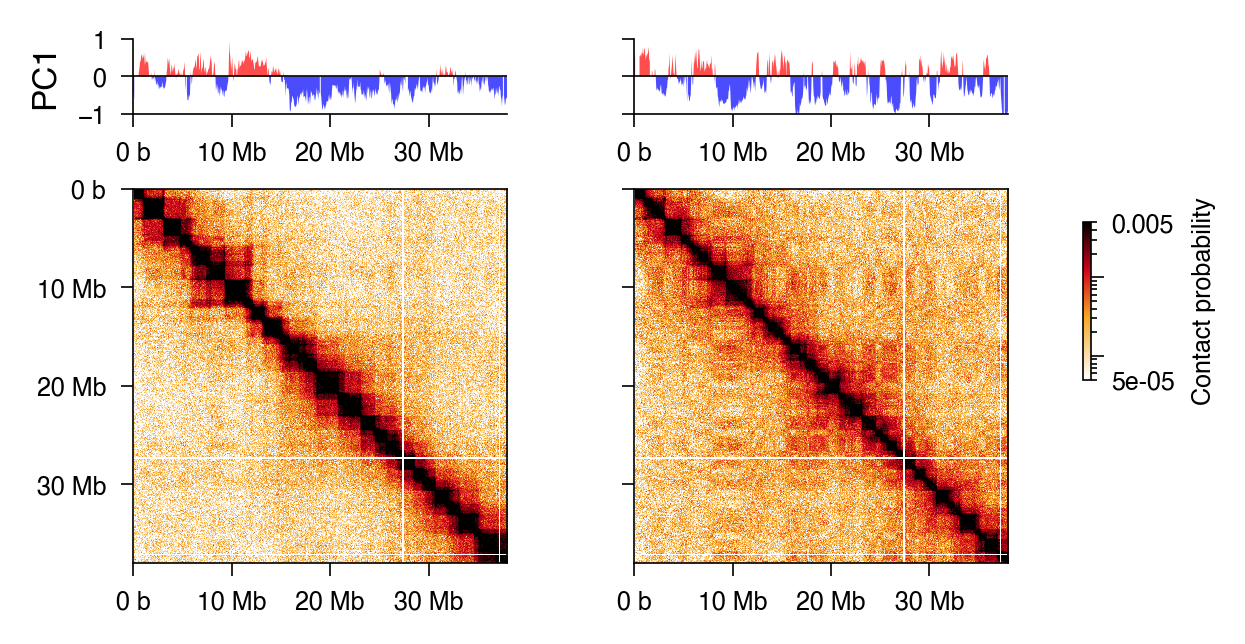

In [11]:
# Draw eigenvectors
bp_formatter = EngFormatter('b')


def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1e7))
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1e7))
        ax.xaxis.tick_bottom()


class MinOneMaxFormatter(ticker.LogFormatter):
    def set_locs(self, locs=None):
        self._sublabels = set([vmin % 10 * 10, vmax % 10, 1])
 
    def __call__(self, x, pos=None):
        if x not in [vmin, 1, vmax]:
            return ""
        else:
            return "{x:g}".format(x=x)
        

f, axs = plt.subplots(1, 2, figsize=(4, 2), sharey=True, dpi=300, constrained_layout=True)

# Create custom colormap
cmap_colors = np.array([
    [255, 255, 255, 255],
    [245, 166, 35, 255],
    [208, 2, 27, 255],
    [0, 0, 0, 255]
]) / 255
cmap_nodes = [0, 0.4, 0.7, 1]
cust_cmap = LinearSegmentedColormap.from_list("mycmap", list(zip(cmap_nodes, cmap_colors)))

vmin, vmax = 5e-5, 0.005
norm = LogNorm(vmin=vmin, vmax=vmax)

start, end = 0, 38_000_300

reg = ('chr10', start, end)
eig_df_reg = eig_df_sw.loc[clrs[ct][rep].bins().fetch(reg).index]
colors = {'NeuN+': sns.color_palette()[4], 
          'NeuN-': sns.color_palette()[1]}

for i, ct in enumerate(['NeuN+', 'NeuN-']):
    im = axs[i].matshow(
        clrs[ct]['merged'].matrix().fetch(reg),
        norm=norm,
        cmap=cust_cmap,
        extent=(start, end, end, start)
    );
    
    divider = make_axes_locatable(axs[i])
    format_ticks(axs[i])

    ax1 = divider.append_axes("top", size="20%", pad=0.25, sharex=axs[i])
    ax1.plot([start, end], [0,0], 'k', lw=0.4)
    
    eig = 'E1'
    ax1.fill_between(np.arange(start, end, res), 
                     eig_df_reg[f'{eig}.{ct}.merged'].values, 0, 
                     where=eig_df_reg[f'{eig}.{ct}.merged'].values >= 0, 
                     facecolor='red', interpolate=True, alpha=0.7)
    ax1.fill_between(np.arange(start, end, res), 
                     eig_df_reg[f'{eig}.{ct}.merged'].values, 0, 
                     where=eig_df_reg[f'{eig}.{ct}.merged'].values <= 0, 
                     facecolor='blue', interpolate=True, alpha=0.7)
    ax1.set_xlim([start, end])
    ax1.set_ylim([-1, 1])
    ax1.spines["top"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    if i == 0:
        ax1.set_ylabel('PC1')
    if i == 1:
        ax1.yaxis.set_ticklabels([])
    
cb = plt.colorbar(im, ax=axs[1], format=MinOneMaxFormatter(), shrink=0.3)
cb.ax.yaxis.set_minor_formatter(MinOneMaxFormatter())
cb.ax.set_ylabel('Contact probability', fontsize=6, rotation=90)

# Count regions that switched compartments

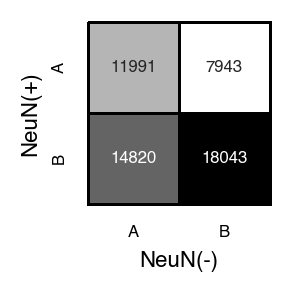

In [12]:
comp_switch = np.zeros((2, 2))
"""
comp_switch array:
         _ _
NeuN+ A |_|_|
      B |_|_|
         A B
        NeuN-
"""
comp_switch[0, 0] = \
    eig_df_sw.loc[(eig_df_sw['E1.NeuN+.merged'] > 0) & 
                  (eig_df_sw['E1.NeuN-.merged'] > 0)].shape[0]
comp_switch[0, 1] = \
    eig_df_sw.loc[(eig_df_sw['E1.NeuN+.merged'] > 0) & 
                  (eig_df_sw['E1.NeuN-.merged'] < 0)].shape[0]
comp_switch[1, 0] = \
    eig_df_sw.loc[(eig_df_sw['E1.NeuN+.merged'] < 0) & 
                  (eig_df_sw['E1.NeuN-.merged'] > 0)].shape[0]
comp_switch[1, 1] = \
    eig_df_sw.loc[(eig_df_sw['E1.NeuN+.merged'] < 0) & 
                  (eig_df_sw['E1.NeuN-.merged'] < 0)].shape[0]

plt.figure(dpi=200, figsize=(1.5, 1.5))
sns.heatmap(comp_switch, annot=True, fmt='.0f', cmap='Greys', cbar=False, 
            linewidths=1, linecolor='k',
            annot_kws={'fontsize': 6})
plt.axis('equal')
plt.xticks([0.5, 1.5], ['A', 'B'])
plt.yticks([0.5, 1.5], ['A', 'B'])
plt.tick_params(which='both', width=0)
plt.xlabel('NeuN(-)')
plt.ylabel('NeuN(+)')

plt.tight_layout()

# Saddle plot

In [13]:
# Compute per-diagonal mean value (expected) 
cvd = {ct: {} for ct in cts}

for ct in cts:
    for rep in reps:
        print(ct, rep)
        cvd[ct][rep] = cooltools.expected_cis(
            clrs[ct][rep],
            view_df=hg38_arms,
            smooth=False,
            nproc=5
        )

NeuN+ R1
NeuN+ R2
NeuN+ R3
NeuN+ R4
NeuN+ merged
NeuN- R1
NeuN- R2
NeuN- R3
NeuN- R4
NeuN- merged


## Whole-genome saddle

In [14]:
interaction_sum = {ct: {} for ct in cts}
interaction_count = {ct: {} for ct in cts}
saddle_nbins = 50

for ct in cts:
    for rep in reps:
        interaction_sum[ct][rep], interaction_count[ct][rep] = cooltools.saddle(
            clrs[ct][rep],
            cvd[ct][rep],
            eig_df_sw[['chrom','start','end', f'E1.NeuN-.{rep}']],
            'cis',
            n_bins=saddle_nbins,
            qrange=(0.025, 0.975),
            view_df=hg38_arms,
            min_diag=4,
        )

/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_di

/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/ipykernel_launcher.py:208: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


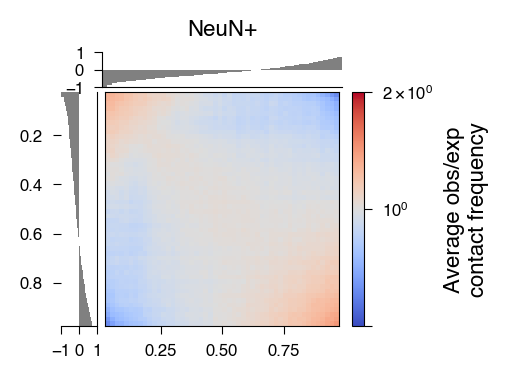

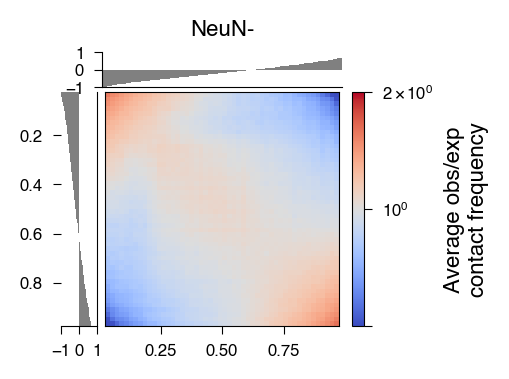

In [15]:
sp ={}
for ct in cts:
    for rep in ['merged']:
        plot, sp[ct] =  saddleplot(
            eig_df[['chrom','start','end', f'E1.{ct}.{rep}']],
            interaction_sum[ct][rep] / interaction_count[ct][rep],
            saddle_nbins,
            cmap='RdBu_r',
            qrange=(0.025, 0.975),
            cbar_kws={'label':'Average obs/exp\ncontact frequency'},
            fig_kws={'dpi': 200, 'figsize': [2, 2]},
            title=ct,
            scale='log',
            vmin=1/2, vmax=2,
            margin_kws={'facecolor': 'grey'}
        );

## Saddle ratio (Figure 1H)

/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/ipykernel_launcher.py:208: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


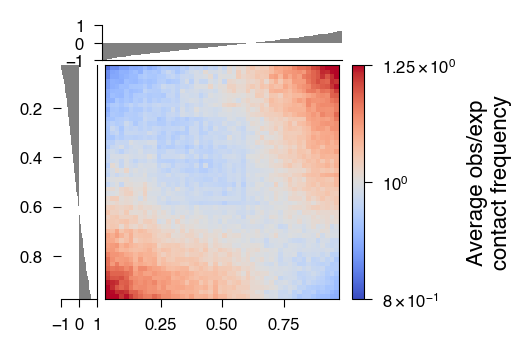

In [16]:
colors = {'NeuN+': sns.color_palette()[4], 
          'NeuN-': sns.color_palette()[1]}
sp = {}

m_neu = interaction_sum['NeuN+']['merged'] / interaction_count['NeuN+']['merged']
m_gli = interaction_sum['NeuN-']['merged'] / interaction_count['NeuN-']['merged']

plot, sp[ct] =  saddleplot(
    eig_df[['chrom','start','end', 'E1.NeuN-.merged']],
    m_neu / m_gli,
    saddle_nbins,
    cmap='RdBu_r',
    qrange=(0.025, 0.975),
    cbar_kws={'label':'Average obs/exp\ncontact frequency'},
    fig_kws={'dpi': 200, 'figsize': [2, 2]},
    title='',
    scale='log',
    vmin=1/1.25, vmax=1.25,
    margin_kws={'facecolor': 'grey'}
);

## Interaction strength (Figure 1I)

Text(0.5, 1.0, 'Interaction strength')

<Figure size 900x600 with 0 Axes>

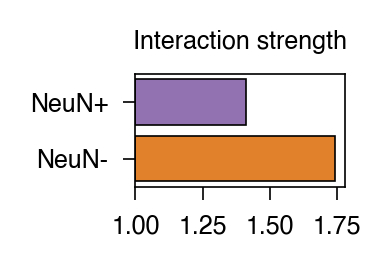

In [17]:
## Plot interaction strength (merged)
plt.figure(dpi=150)
figs = []
labels = ['Intra / Inter']
x = np.arange(len(labels))
colors = {'NeuN+': sns.color_palette()[4], 
          'NeuN-': sns.color_palette()[1]}
nbins_corner = saddle_nbins // 5

ct_arr, group_arr, strnth_arr = [], [], []
for ct in cts:
    ct_arr.extend([ct])

    mat = (interaction_sum[ct]['merged'] / interaction_count[ct]['merged'])[1:-1, 1:-1]
    AB = np.nanmean(mat[:nbins_corner, -nbins_corner:])
    AABB = np.nanmean([mat[-nbins_corner:, -nbins_corner:], 
                       mat[:nbins_corner, :nbins_corner]])

    group_arr.append(u'Intra / Inter')
    strnth_arr.append(AABB / AB - 1)

plot_df = pd.DataFrame(data={
    'ct': ct_arr,
    'group': group_arr,
    'strnth': strnth_arr
})

plt.figure(figsize=(0.9, 0.5), dpi=300)
sns.barplot(data=plot_df, x='strnth', y='ct', ci=None, orient='h',
            linewidth=0.4, edgecolor='k', palette=colors, left=1)
plt.xticks([1, 1.25, 1.5, 1.75])

plt.xlabel('')
plt.ylabel('')
plt.title('Interaction strength', fontsize=6)

Text(0.5, 1.0, 'Interaction strength')

<Figure size 900x600 with 0 Axes>

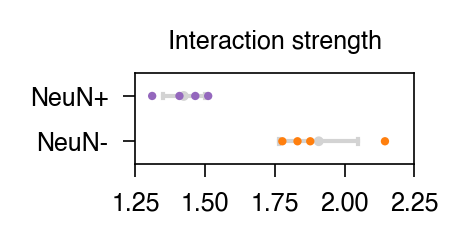

In [18]:
## Plot interaction strength (reps)
plt.figure(dpi=150)
figs = []
labels = ['Intra / Inter']
x = np.arange(len(labels))
colors = {'NeuN+': sns.color_palette()[4], 
          'NeuN-': sns.color_palette()[1]}
nbins_corner = saddle_nbins // 5

ct_arr, group_arr, strnth_arr = [], [], []
for ct in cts:
    for rep in reps:
        if rep == 'merged':
            continue
        ct_arr.extend([ct])

        mat = (interaction_sum[ct][rep] / interaction_count[ct][rep])[1:-1, 1:-1]
        AB = np.nanmean(mat[:nbins_corner, -nbins_corner:])
        AABB = np.nanmean([mat[-nbins_corner:, -nbins_corner:], 
                           mat[:nbins_corner, :nbins_corner]])

        group_arr.append(u'Intra / Inter')
        strnth_arr.append(AABB / AB)

plot_df = pd.DataFrame(data={
    'ct': ct_arr,
    'group': group_arr,
    'strnth': strnth_arr
})

plt.figure(figsize=(1.2, 0.4), dpi=300)
sns.pointplot(data=plot_df, x='strnth', y='ct', 
              linestyles='', ci='sd', color='lightgrey', errwidth=1, capsize=0.1)
sns.swarmplot(data=plot_df, x='strnth', y='ct', orient='h',
              s=2, palette=colors)
plt.xticks([1.25, 1.5, 1.75, 2, 2.25])

plt.xlabel('')
plt.ylabel('')
plt.title('Interaction strength', fontsize=6)